<a href="https://colab.research.google.com/github/FernandaECC/GAN_Rhythms/blob/main/gan_ritmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import PIL
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import numpy as np

import random

MAIN_PATH = "/content/drive/MyDrive/IC/gan/images"


In [ ]:
image_paths = glob(MAIN_PATH+"/*")

In [ ]:
len(image_paths)

100

In [ ]:
def readImage(path,image_size=(256,256)):
    img = np.asarray(PIL.Image.open(path).resize(image_size))
    # img - 127.5 / 127.5 ==> compress between [-1,1]
    img = ((img - 127.5) / 127.5).astype("float32")
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


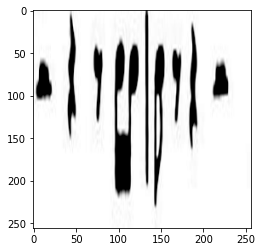

In [ ]:
test_img = readImage("/content/drive/MyDrive/IC/gan/images/85.jpg")
print(test_img.shape)

plt.imshow(test_img)
plt.show()

In [ ]:
BATCH_SIZE = 64
#STEPS_PER_EPOCH = len(image_paths) // BATCH_SIZE
#1582 steps are too many steps. Let's just train for 500 steps.

STEPS_PER_EPOCH = 500 #mudar aqui?
print("Steps per epochh are",STEPS_PER_EPOCH)
def dataGenerator(batch_size):
    while True:
        paths = random.choices(image_paths,k=batch_size)
        batch = []
        for p in paths:
            batch.append(readImage(p))
        
        yield np.asarray(batch)

dataGen = dataGenerator(BATCH_SIZE)
print(next(dataGen).shape)


Steps per epochh are 500
(64, 256, 256, 3)


In [ ]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.2)
def make_generator():
    model = tf.keras.Sequential()
    
    # Random noise to 16x16x256 image
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,16,256)))
    
    assert model.output_shape == (None,16,16,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,32,32,128)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,64,64,128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,128,128,64)
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT,
                                     activation="tanh"
                                    ))
              # Tanh activation function compress values between -1 and 1. 
              # This is why we compressed our images between -1 and 1 in readImage function.
    assert model.output_shape == (None,256,256,3)
    return model

In [ ]:
generator = make_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0

In [ ]:
# we'll use cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # First argument of loss is real labels
    # We've labeled our images as 1 (real) because
    # we're trying to fool discriminator
    return cross_entropy(tf.ones_like(fake_output),fake_output)

gen_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(256,256,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator = make_discriminator()

In [ ]:
def discriminator_loss(real_images,fake_images):
    real_loss = cross_entropy(tf.ones_like(real_images),real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [ ]:
EPOCHS = 10
NOISE_DIM = 100

@tf.function
def train_step(images):
    # We've created random seeds
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator generated images
        generated_images = generator(noise,training=True)
        
        # We've sent our real and fake images to the discriminator
        # and taken the decisions of it.
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        # We've computed losses of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    # We've computed gradients of networks and updated variables using those gradients.
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [ ]:
import time
import sys
def train(epochs):
    for epoch in range(epochs):
        start = time.time()
        for step in range(STEPS_PER_EPOCH):
            train_step(next(dataGen))
    
            sys.stdout.write(f"\rSTEP: {step}/{STEPS_PER_EPOCH}")
            sys.stdout.flush()
            
        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)

In [ ]:
train(EPOCHS)

STEP: 294/500

In [ ]:
#train(3)

In [ ]:
noise = tf.random.normal([25,100])
generated_images = np.asarray(generator(noise,training=False))

fig = plt.figure(figsize=(15,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")
    
plt.show()

https://www.kaggle.com/shyambhu/introduction-to-face-generation-using-dcgan/comments